## This notebook is for creating a study area map for the Salish Sea

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
#from mpl_toolkits.basemap import Basemap
from scipy.io import loadmat
import cmocean
import datetime as dt
import datetime
import warnings
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from salishsea_tools import viz_tools, places
import glob
import gsw
from mocsy import mocsy
#import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 11
warnings.simplefilter('ignore')

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)

In [3]:
def plot_basemap(ax, w_map, color='Burlywood', lons=None, lats=None, loc=None, offset=[None, None], fill=True, zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.arange(*np.floor([w_map[0], w_map[1] + 1]))
    if lats is None:
        lats = np.arange(*np.floor([w_map[2], w_map[3] + 1]))
    
    # Labels
    if loc == 1:
        labels = [[0, 0, 1, 0], [0, 1, 0, 0]]
    elif loc == 2:
        labels = [[0, 0, 1, 0], [1, 0, 0, 0]]
    elif loc == 3:
        labels = [[0, 0, 0, 1], [1, 0, 0, 0]]
    elif loc == 4:
        labels = [[0, 0, 0, 1], [0, 1, 0, 0]]
    else:
        labels = [[0, 0, 0, 1], [1, 0, 0, 0]]
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    if fill:
        m.fillcontinents(color=color, zorder=zorder[0])
    m.drawmeridians(lons, labels=labels[0], color='k', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(lats, labels=labels[1], color='k', xoffset=offset[0], zorder=zorder[2])
    m.drawrivers(zorder=zorder[2])
    
    return m


In [4]:
date = datetime.datetime(2019, 6, 1)    # Creating datetime object works properly
print(date)   


2019-06-01 00:00:00


In [5]:
# Load grid and mask files
grid = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc', mask_and_scale=False)
mask = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc')

In [6]:
tmask = mask['tmask']
deptht = mask['gdept_1d'][0]

In [7]:
month = xr.open_dataset('/data/sallen/results/MEOPAR/202111/SalishSea_1m_201506_201506_carp_T.nc')
temps = xr.open_dataset('/data/sallen/results/MEOPAR/202111/SalishSea_1m_201506_201506_grid_T.nc')


In [8]:
ii, ij = 0,898 
ji, jj = 0, 398

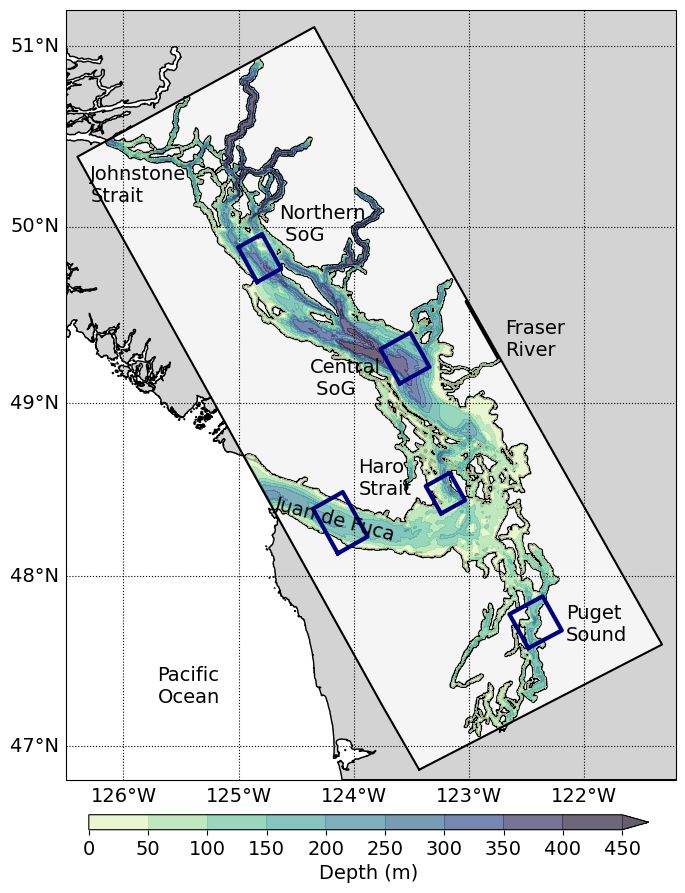

In [55]:
import matplotlib.ticker as mticker

# Increase font size
plt.rcParams['font.size'] = 14


# Add Thalweg if needed
navlon=mask.variables['nav_lon'][:,:]
navlat=mask.variables['nav_lat'][:,:]
thalweg_pts = np.loadtxt('/data/nsoontie/MEOPAR/tools/bathymetry/thalweg_working.txt', delimiter=' ', dtype=int)
thlons=[navlon[jj,ii] for (jj,ii) in thalweg_pts]
thlats=[navlat[jj,ii] for (jj,ii) in thalweg_pts]

# Make plot area
xlim, ylim = [-126.5, -121.2], [46.8, 51.2]
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='lightgrey'))



# Overlay domain landmask and coastline
for attr, color in zip(['contourf', 'contour'], ['whitesmoke', 'k']):
    getattr(ax, attr)(
        grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...],
        levels=[-0.01, 0.01], colors=color, transform=crs.PlateCarree(), zorder=2,
    )

## Draw box around domain
lons, lats = [], []
corners = (0, 0), (0, -1), (-1, -1), (-1, 0), (0, 0)
for i in corners: lons.append(grid.nav_lon[i]), lats.append(grid.nav_lat[i])
ax.plot(lons, lats, 'k-', transform=crs.PlateCarree(), zorder=2)

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

# Add annotations
ax.text(0.15, 0.1, 'Pacific\nOcean', transform=ax.transAxes)
ax.text(0.82, 0.18, 'Puget\nSound', transform=ax.transAxes,color='k')
ax.text(0.34, 0.31, 'Juan de Fuca', transform=ax.transAxes, rotation=-15,color='k') #,weight='bold'
ax.text(0.40, 0.50, 'Central\n SoG', transform=ax.transAxes,color='k')#,weight='bold'
ax.text(0.35, 0.70, 'Northern\n SoG', transform=ax.transAxes,color='k')#,weight='bold'
#ax.text(0.03, 0.77, 'Johnstone', transform=ax.transAxes, rotation=-20)
#ax.text(0.17, 0.70, 'Strait', transform=ax.transAxes, rotation=-65)
ax.text(0.04, 0.75, 'Johnstone\nStrait', transform=ax.transAxes, rotation=0)
ax.text(0.48, 0.37, 'Haro\nStrait', transform=ax.transAxes,color='k')
#ax.text(0.17, 0.6, 'Baynes\nSound', transform=ax.transAxes)
#ax.text(0.32, 0.85, 'Discovery\nIslands', transform=ax.transAxes)
#ax.text(0.36, 0.7, 'Texada\nIsland', transform=ax.transAxes)
ax.text(0.72, 0.55, 'Fraser\nRiver', transform=ax.transAxes)
#ax.text(0.01, 1.01, '(a)', transform=ax.transAxes)
#ax.arrow(0.55, 0.39, 0.04, 0, head_width=0.020, edgecolor='m', facecolor='m', transform=ax.transAxes, zorder=10)
#ax.arrow(0.4, 0.69, 0, -0.03, head_width=0.015, edgecolor='r', facecolor='r', transform=ax.transAxes, zorder=10)
#ax.arrow(0.33, 0.84, -0.03, -0.04, head_width=0.015, edgecolor='r', facecolor='r', transform=ax.transAxes, zorder=10)


# Plot Thalweg
#p=ax.plot(thlons,thlats,'r-', transform=crs.PlateCarree(), linewidth=1)

# Plot Box around Central SoG

# Add rectangles
#locs = [((0.54, 0.52), 0.05, 0.075)]
#for loc, label in zip(locs, ['Central SoG']):
#    ax.add_patch(Rectangle(*loc, color='w', linewidth=2, fill=False, transform=ax.transAxes, zorder=10,angle=0))
#    ax.text(loc[0][0] + 0.02, loc[0][1] + loc[2] - shift, label, transform=ax.transAxes, fontdict={'weight': 'bold'})

#CentralSoG = [450, 500,250,300]
CSoGlons, CSoGlats = [], []
CSoGcorners = (450,250), (450, 300), (500,300), (500,250), (450,250) #250, 450
for i in CSoGcorners: CSoGlons.append(grid.nav_lon[i]), CSoGlats.append(grid.nav_lat[i])
ax.plot(CSoGlons, CSoGlats, 'navy', linewidth=3, transform=crs.PlateCarree(), zorder=2)

#JdF = [300,365, 50, 100] 
JdFlons, JdFlats = [], []
JdFcorners = (300,50), (300, 100), (365,100), (365,50), (300,50) 
for i in JdFcorners: JdFlons.append(grid.nav_lon[i]), JdFlats.append(grid.nav_lat[i])
ax.plot(JdFlons, JdFlats, 'navy', linewidth=3, transform=crs.PlateCarree(), zorder=2)    
    
#Haro = [280,320, 210, 250]   
Harolons, Harolats = [], []
Harocorners = (280,210), (280, 250), (320,250), (320,210), (280,210) 
for i in Harocorners: Harolons.append(grid.nav_lon[i]), Harolats.append(grid.nav_lat[i])
ax.plot(Harolons, Harolats, 'navy', linewidth=3, transform=crs.PlateCarree(), zorder=2)  


#NorthernSoG = [650,700, 140,180]
NSoGlons, NSoGlats = [], []
NSoGcorners = (650,140), (650, 180), (700,180), (700,140), (650,140) 
for i in NSoGcorners: NSoGlons.append(grid.nav_lon[i]), NSoGlats.append(grid.nav_lat[i])
ax.plot(NSoGlons, NSoGlats, 'navy', linewidth=3, transform=crs.PlateCarree(), zorder=2)  

#Puget = [75,125, 225, 280]
Puglons, Puglats = [], []
Pugcorners = (75,225), (75, 280), (125,280), (125,225), (75,225) 
for i in Pugcorners: Puglons.append(grid.nav_lon[i]), Puglats.append(grid.nav_lat[i])
ax.plot(Puglons, Puglats, 'navy', linewidth=3, transform=crs.PlateCarree(), zorder=2)  
levels = np.linspace(7.7, 8.3, 10)

# Mask land (where tmask[0, 0, :, :] == 0)
#bathymetry_masked = np.ma.masked_where(mask.tmask[0, 0, :, :] == 0, grid.Bathymetry)

## Overlay bathymetry
c = ax.contourf(
    grid.nav_lon, grid.nav_lat, bathymetry_masked, levels=np.arange(0, 451, 50),
    cmap=cmocean.cm.deep, extend='max', transform=crs.PlateCarree(), alpha=0.7,zorder=2,
)

# Colorbar
cax = fig.add_axes([0.16, 0.06, 0.7, 0.015])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth (m)')

# Set colorbar tick labels to 2 decimal places
#cb.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))


# Save figure
#plt.savefig('Fig1a_MapofSalishSea_revised.png', bbox_inches='tight',dpi=1000,transparent=False)